# Focus Area 1 — Ground Observations Monitoring &amp; QC
**Core Objective**: To equip NMHS participants with tools for quality-controlling ground station
data and validating it against satellite products, enabling identification of network issues and
building confidence in observational networks.

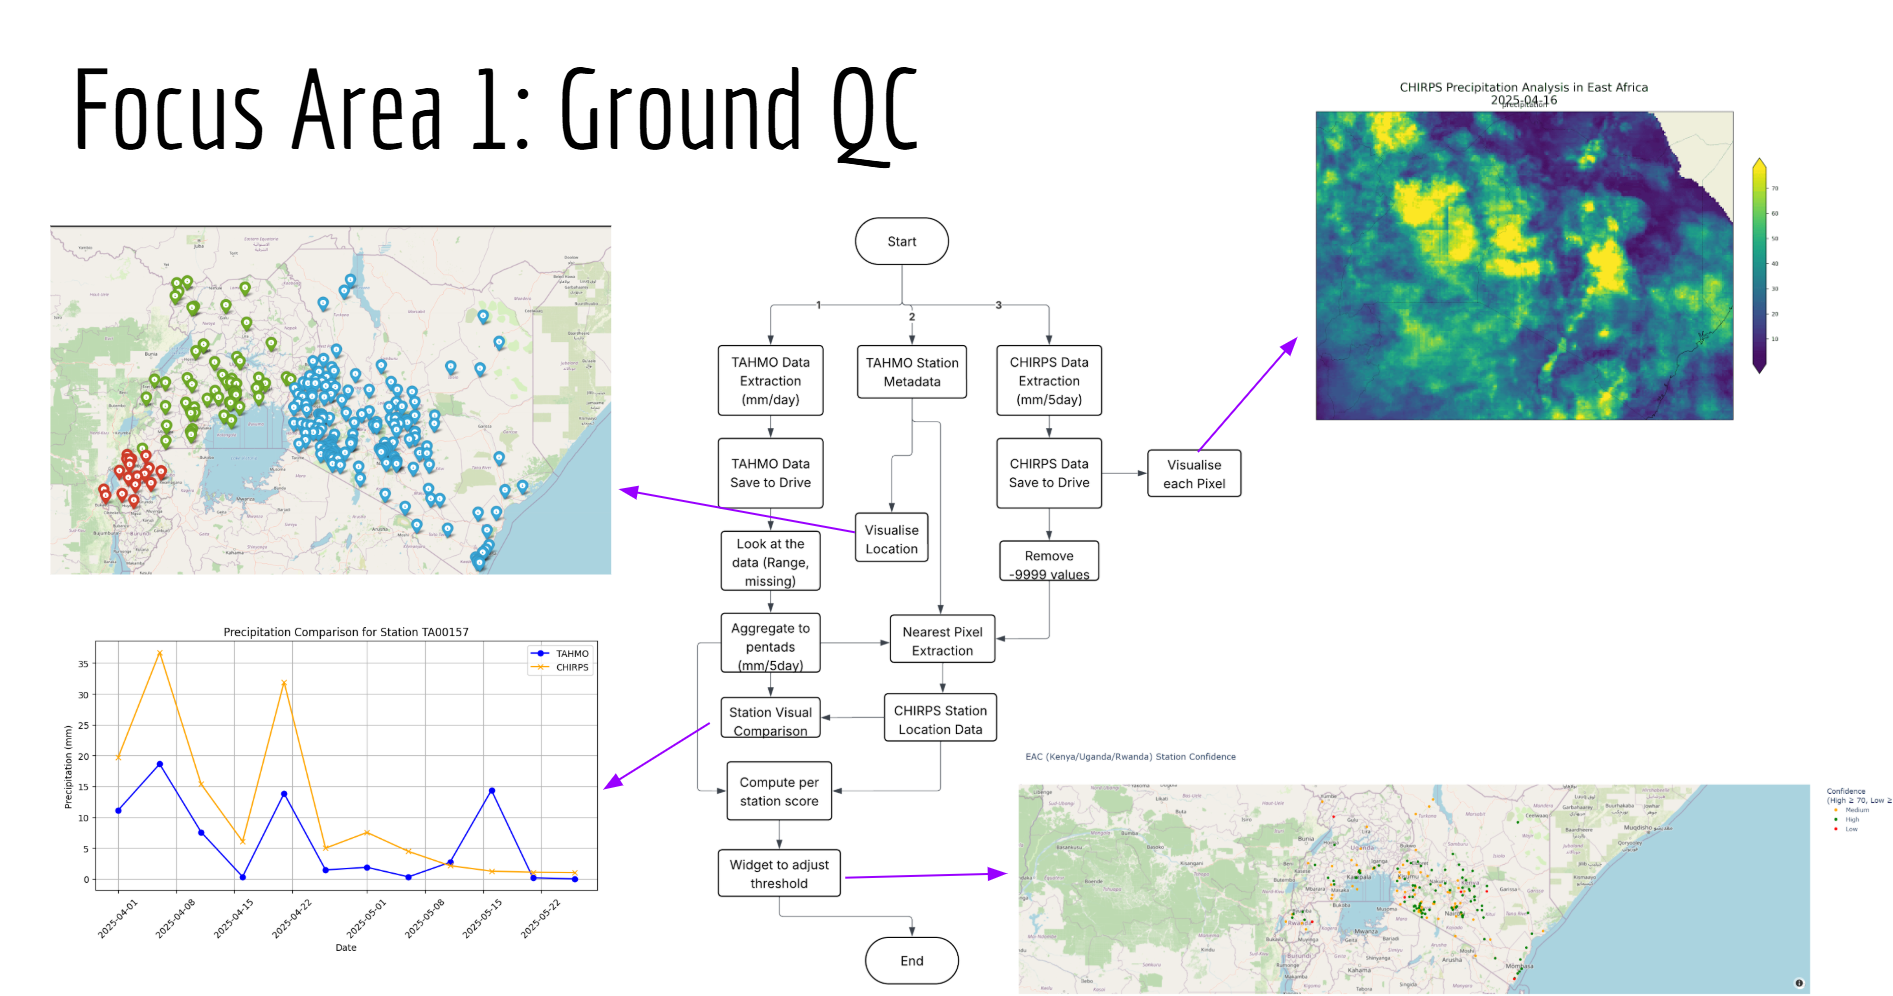

Require 2 files
- The Metadata file: TAHMO_Metadata.csv
- The TAHMO data file: TAHMO_data.csv

Metadata file format (Columns):
<!DOCTYPE html>
<html>
<head>
    <title>TAHMO Metadata</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>lat</th>
            <th>lon</th>
        </tr>
        <tr>
            <td>TA00283</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Data file format (Columns): Temperature / Precipitation data for multiple stations
<html>
<head>
    <title>TAHMO Data</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>TA00283</th>
            <th>TA00284</th>
            <th>TA00285</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Steps Breakdown
- Step 1: Setting up environment and Authentication

- Data Extraction
    - Step2: Select your region of interest to extract data and perform QC
    - Step3: Filter and visualise the metadata for the region of interest plus the precipitation data extraction
    - Step4: CHIRPS data extraction

- Data Processing and QC

    - Step5: Load the extracted data (Ground + Satellite)
    - Step6: Look at the data (Range, missing)
    - Step7: Aggregate the Ground data to Pentads
    - Step8: Build CHIRPS Nearest data from ground station AND visual comparison
    - Step9: Compute per station score visualising the high/medium/low scores

  
  We suggest running this for 1 particular region then store the results then rerun from step 2 with the different region then do a comparison of the errors on step 10

For any questions or concerns reach out please send an email to kaburiaaustin1@tahmo.org

In [ ]:
# @title Step 1a: Setting up environment installing required Dependencies
# @markdown This cell installs the required dependencies for the workshop. It may take a few minutes <br>
# @markdown If you encounter any errors, please restart the runtime and try again. <br>
# @markdown If the error persists, please seek help.


print("Installing required dependencies...")
!pip install git+https://github.com/kaburia/NOAA-workshop.git > /dev/null 2>&1

!jupyter nbextension enable --py widgetsnbextension

# check there was no error
import sys
if not sys.argv[0].endswith("kernel_launcher.py"):
    print("❌ Errors occurred during installation. Please restart the runtime and try again.")
else:
    print("✅ Dependencies installed successfully.")

print("Importing required libraries...")
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel

# import os
# os.chdir('NOAA-workshop')

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data, plot_xarray_data2
from google.colab import drive

%matplotlib inline

print("✅ Libraries imported successfully.")

Installing required dependencies...
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
✅ Dependencies installed successfully.
Importing required libraries...
✅ Libraries imported successfully.


In [ ]:
# @title ### Step 1b: Authentication Step
# @markdown This step is used to authenticate you as a user and there will be two popups that will be doing this.
# @markdown 1. **Authentication to Google Drive** - This is where we shall be loading the data after we have extracted it
# @markdown 2. **Authentication to Google Earth Engine** - This will be used to extract the CHIRPS data and any other satellite product we shall be extracting in the future.
# @markdown Please check your email we shared an invitation to our Google Cloud Project that we shall be using to extract the data<br>
# @markdown *PS: In the future, to create your own project, please refer to [Google Cloud's Documentation](https://developers.google.com/earth-engine/guides/access) that shows the step by step breakdown of creating a Google Cloud Project and enabling Google Earth Engine*
# @markdown  Link to configure noncommercial use of Google Earth Engine: https://console.cloud.google.com/earth-engine/configuration <br>
# @markdown For this workshop, we have created the ```noaa-tahmo``` project that you can input as your project id

print("Authenticating to Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive authenticated successfully.")

import ee

# Authenticate and initialise Google Earth Engine
# This will open a link in your browser to grant permissions if necessary.
try:
    print("Authenticating Google Earth Engine. Please follow the instructions in your browser.")
    ee.Authenticate()
    print("✅ Authentication successful.")
except ee.auth.scopes.MissingScopeError:
    print("Authentication scopes are missing. Please re-run the cell and grant the necessary permissions.")
except Exception as e:
    print(f"Authentication failed: {e}")

# Initialize Earth Engine with your project ID
# Replace 'your-project-id' with your actual Google Cloud Project ID
# You need to create an unpaid project manually through the Google Cloud Console
print("\nIf you already have a project id paste it below. If you do not have a project You need to create an unpaid project manually through the Google Cloud Console")
print("💡 You can create a new project here: https://console.cloud.google.com/projectcreate and copy the project id")
try:
    # It's recommended to use a project ID associated with your Earth Engine account.
    print("\nEnter your Google Cloud Project ID: ")
    project_id = input("")
    ee.Initialize(project=project_id)
    print("✅ Google Earth Engine initialized successfully.")
except ee.EEException as e:
    if "PERMISSION_DENIED" in str(e):
        print(f"Earth Engine initialization failed due to PERMISSION_DENIED.")
        print("Please ensure the Earth Engine API is enabled for your project:")
        print("Enable the Earth Engine API here: https://console.developers.google.com/apis/api/earthengine.googleapis.com/overview?project=elated-capsule-471808-k1")
    else:
        print(f"Earth Engine initialization failed: {e}")
except Exception as e:
    print(f"An unexpected error occurred during initialization: {e}")

Authenticating to Google Drive...
Mounted at /content/drive
✅ Google Drive authenticated successfully.
Authenticating Google Earth Engine. Please follow the instructions in your browser.
✅ Authentication successful.

If you already have a project id paste it below. If you do not have a project You need to create an unpaid project manually through the Google Cloud Console
💡 You can create a new project here: https://console.cloud.google.com/projectcreate and copy the project id

Enter your Google Cloud Project ID: 
noaa-tahmo
✅ Google Earth Engine initialized successfully.


In [23]:
# @title Step 1c: Pick a start and end date
import ipywidgets as widgets
from IPython.display import display
import datetime

# Create date pickers
start_picker = widgets.DatePicker(
    description='Start Date',
    value=datetime.date(2025, 4, 1),
    disabled=False
)

end_picker = widgets.DatePicker(
    description='End Date',
    value=datetime.date(2025, 9, 30),
    disabled=False
)
display(start_picker, end_picker)

start_date = str(start_picker.value)
end_date = str(end_picker.value)

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

DatePicker(value=datetime.date(2025, 4, 1), description='Start Date', step=1)

DatePicker(value=datetime.date(2025, 9, 30), description='End Date', step=1)

Start Date: 2025-04-01
End Date: 2025-09-30


In [25]:
# @title Step 1d: Please upload the provided config file
from google.colab import files
uploaded = files.upload()

Saving config.json to config (1).json


## Data Extraction
- Accesssing TAHMO Data and CHIRPS Data

We are going to create a Google Drive to be able to export the extracted datasets to this location and we can always load them later<br>

A config file is provided with the api keys to access TAHMO Data
```json
{
    "apiKey": "",
    "apiSecret": "",
    "location_keys": ""

}

```

In [34]:
# @title Step 2: Search and Select Region of Interest
# @markdown Enter the name of a country, region, or place in Africa.
# @markdown The Google Maps API will be used to fetch its geometry, bounding box, and show the polygon on a map.

import time
import json
import plotly.graph_objects as go

# --- Load API key ---
with open('/content/config.json', 'r') as f:
    config = json.load(f)

location_key = config['location_keys']  # Google Maps API key

# --- Helper functions ---
def xmin_ymin_xmax_ymax(polygon):
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    return min(lons), min(lats), max(lons), max(lats)

def fetch_region(query):
    """Fetch polygon geometry and bounding box for region name"""
    region_geom = get_region_geojson(query, location_key)['geometry']['coordinates'][0]
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    print(f"✅ Selected: {query}")
    print(f"Bounding box -> xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
    return region_geom, (xmin, ymin, xmax, ymax)

def show_region_plotly(polygon, region_name="Region", margin=0.05):
    """Plot the region polygon with Plotly Mapbox"""
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]

    # Bounding box
    minlon, minlat, maxlon, maxlat = min(lons), min(lats), max(lons), max(lats)
    dlon, dlat = maxlon - minlon, maxlat - minlat
    padlon, padlat = dlon * margin, dlat * margin

    fig = go.Figure()

    # Add polygon
    fig.add_trace(go.Scattermapbox(
        lon=lons + [lons[0]],   # close polygon
        lat=lats + [lats[0]],
        mode="lines",
        line=dict(color="blue"),
        fill="toself",
        fillcolor="rgba(0,0,255,0.3)",
        name=region_name
    ))

    # Layout with cropped bounding box
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox=dict(
            center={"lat": (minlat+maxlat)/2, "lon": (minlon+maxlon)/2},
            zoom=5
        ),
        margin={"r":0,"t":30,"l":0,"b":0},
        height=500,
        title=f"Region of Interest: {region_name}"
    )

    fig.show()
    return fig


# --- User Input ---
time.sleep(2) # Delay to avoid jumping the input
region_query = input("🌍 Enter the name of a region (e.g. Kenya, Uganda, Serengeti):\n")

try:
    region_geom, bbox = fetch_region(region_query)

    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    show_region_plotly(region_geom, region_name=region_query)
except Exception as e:
    print(f"❌ Could not fetch geometry for '{region_query}': {e}")
    print("🔁 Please re-run the cell and try a different region.")

# Normalize query string
region_query = region_query.lower()

# start_date = "2025-04-01"
# end_date = "2025-05-31"

🌍 Enter the name of a region (e.g. Kenya, Uganda, Serengeti):
Uganda
✅ Selected: Uganda
Bounding box -> xmin: 29.573433, ymin: -1.4823178, xmax: 35.0330489, ymax: 4.218628


### Step3: Data Choice

###  Extract TAHMO data using filter-stations

Documentation: https://filter-stations.netlify.app/

Using the method ```get_stations_info()``` to extract the metadata and ```multiple_measurements()``` to extract the precipitation data from multiple stations



In [35]:
# @title Step 3a: Metadata Extraction/Loading and Visualisation
# @markdown At this step we shall also create a directory to start storing the datasets we keep on extracting on Google Drive to easily access and minimize API requests<br>


from utils.filter_stations import RetrieveData
import os
import time

dir_path = '/content/drive/MyDrive/NOAA-workshop-data'
os.makedirs(dir_path, exist_ok=True)
# check if the path was created successfully
if not os.path.exists(dir_path):
    print("❌ Path not created successfully.")
else:
    print("✅ Path created successfully.")

# check if the config exists
if not os.path.exists('/content/config.json'):
    print("❌ Config file not found. Please upload it first.")

import plotly.express as px
import pandas as pd

def plot_stations_plotly(dataframes, colors=None, zoom=5, height=600):
    """
    Plot stations from one or more dataframes on a Plotly mapbox.

    Each dataframe must have 'location.latitude' and 'location.longitude' columns.
    'colors' is a list specifying marker colors for each dataframe respectively.
    """
    if colors is None:
        colors = ["blue", "red", "green", "purple", "orange"]

    frames = []
    for i, df in enumerate(dataframes):
        temp = df.copy()
        temp["color"] = colors[i % len(colors)]  # cycle colors if more dfs than colors
        frames.append(temp)

    combined = pd.concat(frames, ignore_index=True)

    fig = px.scatter_mapbox(
        combined,
        lat="location.latitude",
        lon="location.longitude",
        color="color",
        hover_name="code",
        zoom=zoom,
        height=height
    )

    fig.update_layout(
        mapbox_style="open-street-map",
        legend_title="Dataset Color"
    )

    return fig



api_key = config['apiKey']
api_secret = config['apiSecret']

# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)

# Extracting TAHMO data
print("Extracting TAHMO data...")
info = rd.get_stations_info()
info = info[(info['location.longitude'] >= xmin) &
                        (info['location.longitude'] <= xmax) &
                        (info['location.latitude'] >= ymin) &
                        (info['location.latitude'] <= ymax)]
print("✅ TAHMO data extracted successfully.")
# Print the total number of stations
print(f"Total number of stations: {len(info)}")


# save the data as csv to the created directory
info.to_csv(f'{dir_path}/tahmo_metadata_{region_query}.csv')

# wait for 5 seconds before visual
time.sleep(5)

# Visualise the data
plot_stations_plotly([info], colors=["blue"])

✅ Path created successfully.
Extracting TAHMO data...
✅ TAHMO data extracted successfully.
Total number of stations: 95


In [ ]:
# @title Step 3b: Extracting Precipitation data and visualisation
# @markdown Using filter-stations to extract precipitation data <br>

# save to the directory

# print('Extracting Precipitation Data ...')
region_precip = rd.multiple_measurements(stations_list=info['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['pr'],
                                         csv_file=f'{dir_path}/tahmo_precip_{region_query}')

# check if the file exist to know if it was successful
if not os.path.exists(f'{dir_path}/tahmo_precip_{region_query}.csv'):
    print("❌ Precipitation data not extracted successfully.")
else:
    print("✅ Precipitation data extracted successfully.")

# Visualise any random station data
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

# plot_stations_data_randomly(region_precip)

region_precip

Retrieving data for stations:   0%|          | 0/190 [00:00<?, ?it/s]

✅ Precipitation data extracted successfully.


TA00001  TA00018  TA00019  TA00020  TA00021  \
2025-04-01 00:00:00+00:00    0.000    0.204    0.748    0.051    0.068   
2025-04-02 00:00:00+00:00    0.068    0.187    0.051    0.017    0.017   
2025-04-03 00:00:00+00:00    0.000    0.153    0.000    1.343    0.000   
2025-04-04 00:00:00+00:00   18.485    0.136    2.839    0.833    8.450   
2025-04-05 00:00:00+00:00    3.198    0.136    0.595    0.255    0.391   
...                            ...      ...      ...      ...      ...   
2025-05-27 00:00:00+00:00    0.544    4.066    0.289    0.136    7.150   
2025-05-28 00:00:00+00:00    0.221    5.460    0.187    0.000    0.119   
2025-05-29 00:00:00+00:00    0.187    3.472    0.102    0.000    0.493   
2025-05-30 00:00:00+00:00    0.136   10.049    0.034    0.017    1.938   
2025-05-31 00:00:00+00:00    0.000    0.000    0.000    0.000    0.000   

                          TA00022  TA00023  TA00024  TA00025_S002905  \
2025-04-01 00:00:00+00:00     NaN      NaN    0.068              NaN   
2025-04-02 00:00:00+00:00     NaN      NaN    0.034              NaN   
2025-04-03 00:00:00+00:00     NaN      NaN    0.749              NaN   
2025-04-04 00:00:00+00:00     NaN      NaN    6.446              NaN   
2025-04-05 00:00:00+00:00     NaN      NaN    0.000              NaN   
...                           ...      ...      ...              ...   
2025-05-27 00:00:00+00:00     NaN      NaN      NaN              0.0   
2025-05-28 00:00:00+00:00     NaN      NaN      NaN              0.0   
2025-05-29 00:00:00+00:00     NaN      NaN      NaN              2.4   
2025-05-30 00:00:00+00:00     NaN      NaN    0.000              0.0   
2025-05-31 00:00:00+00:00     NaN      NaN      NaN              0.0   

                           TA00025_S002904  ...  TA00880  TA00884  \
2025-04-01 00:00:00+00:00              NaN  ...    2.058    0.000   
2025-04-02 00:00:00+00:00              NaN  ...    0.000    0.000   
2025-04-03 00:00:00+00:00              NaN  ...   26.300    0.187   
2025-04-04 00:00:00+00:00              NaN  ...    0.000    0.000   
2025-04-05 00:00:00+00:00              NaN  ...   15.214   11.029   
...                                    ...  ...      ...      ...   
2025-05-27 00:00:00+00:00            0.000  ...      NaN    0.000   
2025-05-28 00:00:00+00:00            0.000  ...      NaN    0.017   
2025-05-29 00:00:00+00:00            2.365  ...      NaN    0.000   
2025-05-30 00:00:00+00:00            0.000  ...      NaN    0.000   
2025-05-31 00:00:00+00:00            0.000  ...      NaN    0.000   

                          TA00903_S002980  TA00903_S002979  TA00907  TA00909  \
2025-04-01 00:00:00+00:00             NaN              NaN      NaN      NaN   
2025-04-02 00:00:00+00:00             NaN              NaN      NaN      NaN   
2025-04-03 00:00:00+00:00             NaN              NaN      NaN      NaN   
2025-04-04 00:00:00+00:00             NaN              NaN      NaN      NaN   
2025-04-05 00:00:00+00:00             NaN              NaN      NaN      NaN   
...                                   ...              ...      ...      ...   
2025-05-27 00:00:00+00:00             2.8            2.844      NaN      NaN   
2025-05-28 00:00:00+00:00             0.6            0.500      NaN      NaN   
2025-05-29 00:00:00+00:00             1.0            1.000      NaN      NaN   
2025-05-30 00:00:00+00:00             2.0            1.900      NaN      NaN   
2025-05-31 00:00:00+00:00             0.0            0.000      NaN      NaN   

                          TD00001 TD00002  TD00004  TD00005  
2025-04-01 00:00:00+00:00   19.77    0.00     0.00      NaN  
2025-04-02 00:00:00+00:00    0.00    0.00     0.00      NaN  
2025-04-03 00:00:00+00:00    0.00    1.03     0.53      NaN  
2025-04-04 00:00:00+00:00    0.05    0.01     1.65      NaN  
2025-04-05 00:00:00+00:00    1.38    7.35    14.30      NaN  
...                           ...     ...      ...      ...  
2025-05-27 00:00:00+00:00    2.17     NaN     3.7

In [ ]:
# @title ### Step 4: Extracting CHIRPS data and visualising the data for the query region

# @markdown Extract the data from Google Earth engine project

# @markdown **Note**: For this workshop, we have done this process for you when we shared the Google Cloud invitation to the project

# Define region of interest (Kenya)
roi = ee.Geometry.Polygon(region_geom)

# Extract data for 2020
chirps_ds = get_chirps_pentad_gee(
    start_date=start_date,
    end_date=end_date,
    region=roi,
    export_path=f'{dir_path}/chirps_pentad_{region_query}.nc'
)

# Removing the imputed values resetting to NaN
chirps_ds = chirps_ds.where(chirps_ds != -9999)


plot_xarray_data2(
    xarray_ds=chirps_ds,
    fig_title=f"CHIRPS Precipitation Analysis in {region_query}",
    columns=["precipitation"],
    plot_size=7,
    bbox=[xmin, ymin, xmax, ymax],
    # save=True
)


Total number of images: 12

Exporting 1/12: chirps_temp/20250401.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250401.tif


Exporting 2/12: chirps_temp/20250406.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250406.tif


Exporting 3/12: chirps_temp/20250411.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250411.tif


Exporting 4/12: chirps_temp/20250416.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250416.tif


Exporting 5/12: chirps_temp/20250421.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250421.tif


Exporting 6/12: chirps_temp/20250426.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250426.tif


Exporting 7/12: chirps_temp/20250501.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250501.tif


Exporting 8/12: chirps_temp/20250506.tif
Generating URL

## Data Processing
1. Looking at the data availability
2. Aggregate station rain to pentads to match CHIRPS.
3. Nearest-pixel extraction from CHIRPS and merge with station pentads.
4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for
bias.
5. Combine into a 0–100 confidence score and classify (High/Medium/Low).

Loading the Extracted TAHMO data and metadata

In [ ]:
# @title Step 5: Load the CHIRPS and Ground Precipitation and Metadata
# @markdown This step ensures you can begin from here in the case you lost network or runtime was connected<br>
# @markdown We have been storing the data and you will load this extracted data at this point
import xarray as xr

region_precip_data = pd.read_csv(f'{dir_path}/tahmo_precip_{region_query}.csv')
# eac metadata
region_metadata = pd.read_csv(f"{dir_path}/tahmo_metadata_{region_query}.csv")
region_metadata = region_metadata[['code', 'location.latitude', 'location.longitude']].rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})

# CHIRPS Xarray dataset
chirps_ds = xr.open_dataset(f'{dir_path}/chirps_pentad_{region_query}.nc')
chirps_ds = chirps_ds.where(chirps_ds != -9999)

# Format the TAHMO data
region_precip_data = region_precip_data.rename(columns={"Unnamed: 0": "Date"})
region_precip_data['Date'] = pd.to_datetime(region_precip_data['Date'])
region_precip_data = region_precip_data.set_index('Date')
region_precip_data.index = region_precip_data.index.tz_localize(None)

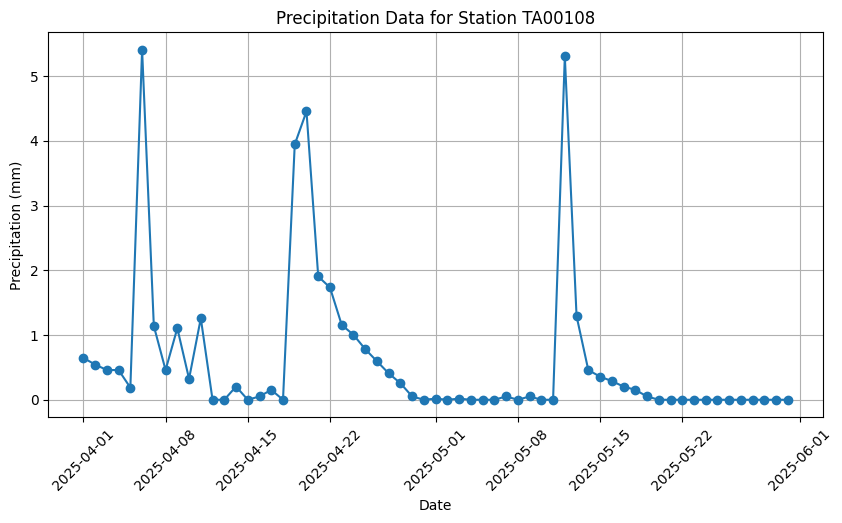

Station Code: TA00108
Data Range: 0.0 mm to 5.406 mm
Number of Records: 61


In [ ]:
# @title Step 6a: Check the range of the data and plot any of the stations randomly
# @markdown Rerun to visualise a random station in the region <br>
# @markdown Every single time you run this cell, you will visualise the data for a station for the period you chose
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

plot_stations_data_randomly(region_precip_data)

In [ ]:
# @title Step 6b: Looking at the data availability for the ground stations
# @markdown You will be visualising the number of missing data in your data
# Get the stations with missing data
missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
# print(f"Stations with missing data: {missing_stations}")
# drop stations with all missing data
region_precip_data = region_precip_data.dropna(how='all', axis=1)
region_precip_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
# print(f"Stations with missing data: {missing_stations}")

# Drop stations with multiple sensors station_sensor columns
multiple_sensors = [i for i in region_precip_data.columns if len(i.split('_')) > 1]
region_precip_data = region_precip_data.drop(columns=multiple_sensors)
region_precip_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per station', figsize=(40, 10))

# Add x and y label
plt.xlabel('Station')
plt.ylabel('Missing Data Count')
plt.show()

# Get the stations with missing data
missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")


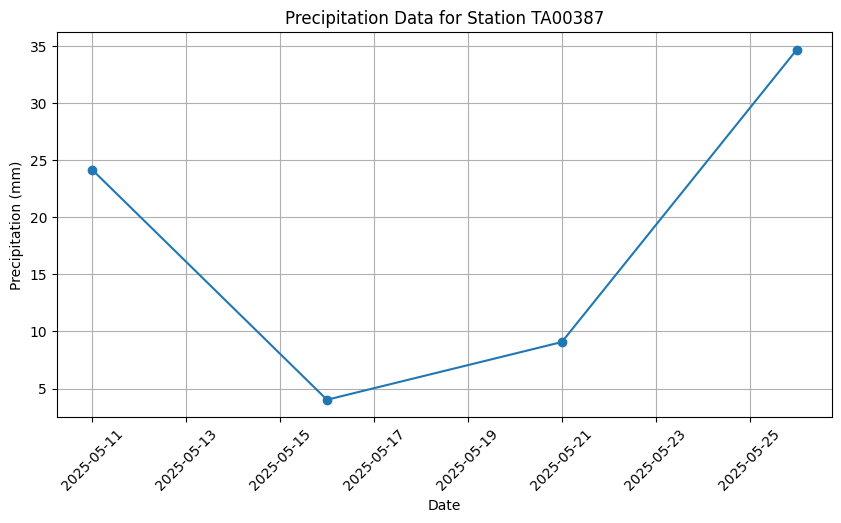

Station Code: TA00387
Data Range: 4.015 mm to 34.667 mm
Number of Records: 12


In [ ]:
# @title Step 7: Aggregate station rain to pentads to match CHIRPS.
# @markdown In order to match CHIRPS and how it is extracted we will aggregate the data to pentads (5 days)
region_precip_pentad = rd.aggregate_variables(region_precip_data, freq='5D', method='sum')[:-1]
plot_stations_data_randomly(region_precip_pentad)


In [ ]:
# @title Step 8a: Nearest-pixel extraction from CHIRPS and merge with station pentads.
# @markdown At this step we are building the CHIRPS station dataset by using the station metadata (latitude and longitude) to get the nearest value of CHIRPS
# filter to the required stations
req_stations = region_precip_pentad.columns.tolist()

region_metadata = region_metadata[region_metadata['code'].isin(req_stations)]

def build_chirps_from_stations(chirps_ds, stations_metadata):
    import xarray as xr
    import pandas as pd

    all_stations_data = {}
    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = row['lat']
        lon = row['lon']

        # Extract nearest pixel data
        station_da = chirps_ds.precipitation.sel(x=lon, y=lat, method="nearest")
        station_df = station_da.to_dataframe().rename(columns={'precipitation': station_code})

        all_stations_data[station_code] = station_df[station_code]

    # Combine all stations into a single DataFrame
    combined_df = pd.DataFrame(all_stations_data)
    return combined_df

chirps_stations = build_chirps_from_stations(chirps_ds, region_metadata)
# plot_stations_data_randomly(chirps_stations)

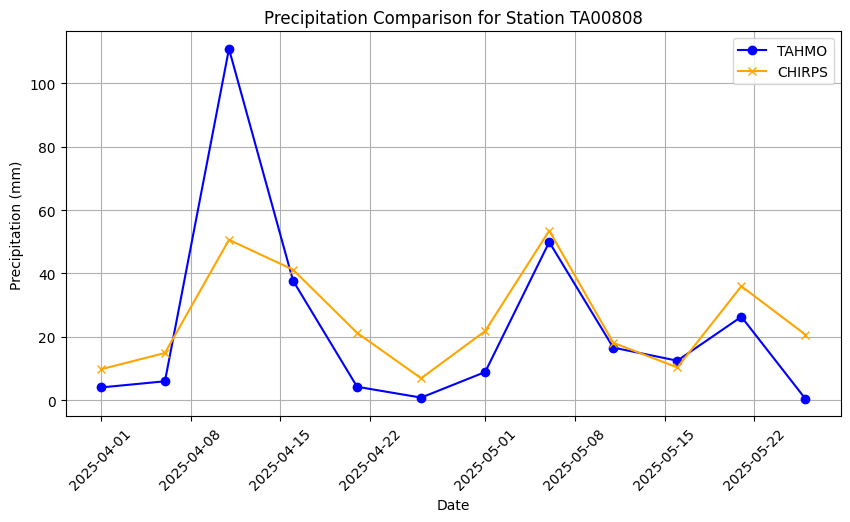

Station Code: TA00808
TAHMO Data Range: 0.408 mm to 110.88 mm
CHIRPS Data Range: 6.88643217086792 mm to 53.498802185058594 mm
Number of TAHMO Records: 12
Number of CHIRPS Records: 12


In [ ]:
# @title Step 8b: Plot the CHIRPS data and TAHMO equivalents for a random station
# @markdown Every single time we run this cell we get to visualise the CHIRPS v Ground data comparison for a different station within the region
def plot_chirps_vs_tahmo_randomly(eac_pentad, chirps_stations):
    import random
    station_codes = eac_pentad.columns.intersection(chirps_stations.columns).tolist()
    if not station_codes:
        print("No common stations between EAC pentad data and CHIRPS data.")
        return

    random_station = random.choice(station_codes)

    tahmo_data = eac_pentad[random_station]
    chirps_data = chirps_stations[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(tahmo_data.index, tahmo_data.values, marker='o', label='TAHMO', color='blue')
    plt.plot(chirps_data.index, chirps_data.values, marker='x', label='CHIRPS', color='orange')
    plt.title(f'Precipitation Comparison for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"TAHMO Data Range: {tahmo_data.min()} mm to {tahmo_data.max()} mm")
    print(f"CHIRPS Data Range: {chirps_data.min()} mm to {chirps_data.max()} mm")
    print(f"Number of TAHMO Records: {len(tahmo_data)}")
    print(f"Number of CHIRPS Records: {len(chirps_data)}")

plot_chirps_vs_tahmo_randomly(region_precip_pentad, chirps_stations)

In [ ]:
# @title Step 9a: Compute Station Scores
# @title Confidence Score Formula
# @markdown ### **Confidence Score Formula**
# @markdown For each station, the confidence score is computed as:
# @markdown
# @markdown $$
# @markdown \text{Confidence Score} = 100 \times \big(0.4 \cdot C \;+\; 0.4 \cdot r \;+\; 0.2 \cdot (1 - O)\big)
# @markdown $$
# @markdown
# @markdown Where:
# @markdown - $C = 1 -$ (missing fraction of observations), i.e. **completeness**
# @markdown - $r =$ Pearson correlation coefficient between observed and CHIRPS pentads
# @markdown - $O =$ fraction of outliers (observed values < 0)
# @markdown
# @markdown ---
# @markdown
# @markdown **Additional metrics per station:**
# @markdown
# @markdown - **RMSE**
# @markdown $$
# @markdown \text{RMSE} = \sqrt{\frac{1}{n} \sum (obs - sim)^2}
# @markdown $$
# @markdown
# @markdown - **Bias significance**
# @markdown Paired $t$-test between observed and simulated values (significant if $p < 0.05$).
# @markdown
# @markdown - **Adjusted confidence score**
# @markdown $$
# @markdown \text{Adjusted Confidence Score} = \text{Confidence Score} - \text{RMSE}
# @markdown $$


def compute_station_scores(eac_pentad, chirps_stations): # returns a dataframe of scores 'station_id','confidence_score','pearson_r','rmse','bias_signif'
    # get the union stations
    stations = eac_pentad.columns.intersection(chirps_stations.columns)
    scores = []
    for station in stations:
        obs = eac_pentad[station]
        sim = chirps_stations[station]

        # Compute metrics
        r, _ = pearsonr(obs, sim)
        error = rmse(obs, sim)
        t_stat, p_val = ttest_rel(obs, sim)
        bias_signif = 'Significant' if p_val < 0.05 else 'Not Significant'
        completeness = 1 - obs.isna().mean()
        outlier_rate = (obs < 0).mean()
        confidence_score = 100 * (0.4 * completeness + 0.4 * np.nan_to_num(r, nan=0) + 0.2 * (1 - outlier_rate))
        scores.append(
            {
                'station_id': station,
                'confidence_score': confidence_score,
                'pearson_r': r,
                'rmse': error,
                'bias_signif': bias_signif,
                'completeness': completeness,
                'outlier_rate': outlier_rate
            }
        )
    scores_df = pd.DataFrame(scores)
    return scores_df

# @title RMSE
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))


station_scores = compute_station_scores(region_precip_pentad, chirps_stations)
# to the confidence scores subtract the rmse
station_scores['adjusted_confidence_score'] = station_scores['confidence_score'] - station_scores['rmse']
station_scores.sort_values(by='adjusted_confidence_score', ascending=False).head(20)

# save the stations with the confidence scores
station_scores.to_csv(f'{dir_path}/station_scores_{region_query}.csv', index=False)


'''
1. Compute the RMSE
2. Compute the Pearson correlation coefficient
3. Compute the ttest for bias
    bias significance (p<0.05) ['Significant' if p_val < 0.05 else 'Not Significant']
4. Compute completeness (% of non-missing values)
        completeness = 1 - g['station_pentad'].isna().mean()
        outlier_rate = (g['station_pentad']<0).mean()
5. confidence_score = 100*(0.4*completeness + 0.4*np.nan_to_num(r, nan=0) + 0.2*(1-outlier_rate))
'''
station_scores.sort_values(by='confidence_score', ascending=False).head(10)


station_id  confidence_score  pearson_r       rmse      bias_signif  \
63     TA00358         97.206761   0.930169  16.067460      Significant   
28     TA00108         94.806537   0.870163  24.647963      Significant   
49     TA00187         94.789766   0.869744  12.572289  Not Significant   
111    TA00831         94.618467   0.865462  10.803124      Significant   
42     TA00172         94.594074   0.864852  25.643137      Significant   
100    TA00787         93.166823   0.829171  13.739472      Significant   
38     TA00156         93.158464   0.828962  17.234239      Significant   
101    TA00808         92.768860   0.819221  19.950135  Not Significant   
127    TD00004         91.888842   0.797221  27.261681      Significant   
30     TA00130         91.343777   0.783594  13.080172  Not Significant   

     completeness  outlier_rate  adjusted_confidence_score  
63            1.0           0.0                  81.139302  
28            1.0           0.0                  70.158574  
49            1.0           0.0                  82.217477  
111           1.0           0.0                  83.815343  
42            1.0           0.0                  68.950937  
100           1.0           0.0                  79.427351  
38            1.0           0.0                  75.924225  
101           1.0           0.0                  72.818725  
127           1.0           0.0                  64.627161  
30            1.0           0.0                  78.263606

In [ ]:
# @title Step 9b: Export to Excel the confidence scores
from google.colab import files
print('Exporting station scores to Excel ...')
station_scores.to_excel(f'{dir_path}/station_scores_{region_query}.xlsx', index=False)
files.download(f'{dir_path}/station_scores_{region_query}.xlsx')

# print('✅ Su')

In [ ]:
# @title Step 9c:Setting the threshold for high and low

import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

def plot_station_vs_chirps_and_confidence_interactive(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    scatter_color="#3366cc"
):
    """
    Scatter: single color (no category legend)
    Geo map: always shows High / Medium / Low categories
    Returns:
      m_long, score_map, scatter_fig, map_fig
    """
    # -------- 1. Build long paired dataset --------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame({'station_pentad': s_obs, 'sat_pentad': s_sat}).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            rows.append(pair)
    if not rows:
        print("No stations with sufficient paired data.")
        return None, None, None, None
    m_long = pd.concat(rows, axis=0).reset_index(drop=True)

    # -------- 2. Always compute classification for map --------
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify_fn(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify_fn)
    # enforce category ordering even if some missing
    cls_order = ['High','Medium','Low']
    sc['class'] = pd.Categorical(sc['class'], categories=cls_order, ordered=True)

    # -------- 3. Merge with metadata --------
    meta = metadata_df.rename(columns={'code':'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left').dropna(subset=['lat','lon'])
    score_map['class'] = pd.Categorical(score_map['class'], categories=cls_order, ordered=True)

    # -------- 4. Merge scores into long paired --------
    merge_cols = ['station_id','confidence_score','class','pearson_r','rmse','completeness','outlier_rate','bias_signif']
    existing = [c for c in merge_cols if c in sc.columns]
    m_long = m_long.merge(sc[existing], on='station_id', how='left')

    # -------- 5. Scatter (single color) --------
    lim_max = float(max(m_long['station_pentad'].max(), m_long['sat_pentad'].max()))
    hover_data = {
        'station_id': True,
        'time': True,
        'station_pentad': ':.2f',
        'sat_pentad': ':.2f',
        'confidence_score': ':.1f',
        'class': True,
        'pearson_r': ':.3f',
        'rmse': ':.2f',
        'completeness': ':.2f',
        'outlier_rate': ':.3f',
        'bias_signif': True
    }
    scatter_fig = px.scatter(
        m_long,
        x='station_pentad',
        y='sat_pentad',
        title=f"{country_label}: Station vs CHIRPS (Pentad)",
        hover_data=hover_data,
        labels={'station_pentad':'Station (mm)','sat_pentad':'CHIRPS (mm)'}
    )
    scatter_fig.update_traces(marker=dict(color=scatter_color))
    scatter_fig.update_layout(showlegend=False)
    scatter_fig.add_trace(
        go.Scatter(
            x=[0, lim_max],
            y=[0, lim_max],
            mode='lines',
            line=dict(dash='dash', color='black'),
            name='1:1'
        )
    )
    scatter_fig.update_xaxes(constrain='domain')
    scatter_fig.update_yaxes(scaleanchor=None)

        # -------- 6. Geo Map (with categories, OSM basemap) --------
    palette = {'High':'green','Medium':'orange','Low':'red'}
    map_fig = px.scatter_mapbox(
        score_map,
        lat='lat',
        lon='lon',
        color='class',
        color_discrete_map=palette,
        hover_name='station_id',
        hover_data={
            'confidence_score': ':.1f',
            'pearson_r': ':.3f',
            'rmse': ':.2f',
            'completeness': ':.2f',
            'outlier_rate': ':.3f',
            'bias_signif': True,
            'lat': ':.3f',
            'lon': ':.3f'
        },
        title=f"{country_label} Station Confidence",
        zoom=5,
        height=600
    )
    # map_fig.update_layout(
    #     legend_title_text='Confidence',
    #     mapbox_style="open-street-map"
    # )
    map_fig.update_layout(
        mapbox_style="open-street-map",
        legend_title_text=f"Confidence<br>(High ≥ {high_thr}, Low < {low_thr})"
    )

    if {'lat','lon'}.issubset(score_map.columns) and len(score_map):
        lat_min, lat_max = score_map['lat'].min(), score_map['lat'].max()
        lon_min, lon_max = score_map['lon'].min(), score_map['lon'].max()
        lat_center = (lat_min + lat_max) / 2
        lon_center = (lon_min + lon_max) / 2
        map_fig.update_layout(
            mapbox_center={"lat": lat_center, "lon": lon_center},
            mapbox_zoom=5
        )


    return m_long, score_map, scatter_fig, map_fig

# Get the user to input the high and low threshold
high_thr = int(input("Enter the high threshold (default 70): ") or 70)
low_thr = int(input("Enter the low threshold (default 40): ") or 40)
print(f"High threshold: {high_thr}")
print(f"Low threshold: {low_thr}")
time.sleep(2)

m_pairs, score_with_meta, scatter_fig, map_fig = plot_station_vs_chirps_and_confidence_interactive(
    region_precip_pentad,
    chirps_stations,
    station_scores,
    region_metadata,
    country_label=f"{region_query}",
    high_thr=high_thr,
    low_thr=low_thr,
    scatter_color="#3366cc"
)

if scatter_fig is not None:
    scatter_fig.show()
    map_fig.show()


Enter the high threshold (default 70): 70
Enter the low threshold (default 40): 30
High threshold: 70
Low threshold: 30


In [ ]:
# @title Step 10: Visualise the comparison
# @markdown In this step we shall load the data for the different regions and compare the stations overall performance <br>
# @markdown We shall visualise the number of high and low confidence stations<br>
# @markdown We are going to collect some inputs from you
# @markdown   - The number of regions
# @markdown   - The names of each of the regions

import plotly.graph_objects as go

# Step 1: The number of regions
num_regions = int(input("Enter the number of regions: "))

# Step 2: Input the name of the first region to load the data
region_list = []
for i in range(num_regions):
    region_name = input(f"Enter the name of region {i+1}: ")
    region_list.append(region_name)


# In the drive search for the high and low confidence scores for these regions
file_format_paths = f'{dir_path}/station_scores_{region_query}.csv'

# create the file formats
file_paths = [f'{dir_path}/station_scores_{i}.csv'  for i in region_list]
file_path_df = []

def classify_conf(v):
    if v >= high_thr: return 'High'
    if v >= low_thr: return 'Medium'
    return 'Low'

# check if the files exist
for file_path in file_paths:
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")

    else:
      # load the data to csv
      scores_st = pd.read_csv(file_path)
      scores_st['class'] = scores_st['confidence_score'].apply(classify_conf)
      file_path_df.append(scores_st)



  # visualise the number of high and low confident stations


def plot_confidence_comparison(list_of_dfs, region_names, high_thr, low_thr):
    """
    Plots a grouped bar chart comparing the number of High, Medium, and Low
    confidence stations across different regions.

    Args:
        list_of_dfs (list): A list of pandas DataFrames, where each DataFrame
                            contains station scores for a region and has a 'class' column.
        region_names (list): A list of strings representing the names of the regions
                             corresponding to the DataFrames in list_of_dfs.
        high_thr (int): The high confidence threshold.
        low_thr (int): The low confidence threshold.
    """

    if len(list_of_dfs) != len(region_names):
        print("Error: The number of DataFrames must match the number of region names.")
        return

    data_for_plot = []
    for df in list_of_dfs:
        # Ensure the 'class' column exists
        if 'class' not in df.columns:
             def classify_fn(v):
                 if v >= high_thr: return 'High'
                 if v >= low_thr: return 'Medium'
                 return 'Low'
             df['class'] = df['confidence_score'].apply(classify_fn)

        counts = df['class'].value_counts().reindex(['High', 'Medium', 'Low'], fill_value=0)
        data_for_plot.append(counts)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data_for_plot, index=region_names)

    # Define colors for High, Medium, Low
    colors = {'High': 'green', 'Medium': 'orange', 'Low': 'red'}

    fig = go.Figure()

    for conf_level in ['High', 'Medium', 'Low']:
        fig.add_trace(go.Bar(
            x=plot_df.index,
            y=plot_df[conf_level],
            name=conf_level,
            marker_color=colors[conf_level]
        ))

    fig.update_layout(
        barmode='group', # Use 'group' for grouped bars, 'stack' for stacked bars
        title=f'Station Confidence Comparison Across Regions (High ≥ {high_thr}, Low < {low_thr})',
        xaxis_title='Region',
        yaxis_title='Number of Stations',
        xaxis_tickangle=-45,
        legend_title='Confidence Level'
    )

    fig.show()

if file_path_df and region_list:
    plot_confidence_comparison(file_path_df, region_list, high_thr, low_thr)
elif not file_path_df:
    print("No valid dataframes loaded for plotting.")
else:
    print("Region list is empty.")

Enter the number of regions: 2
Enter the name of region 1: Nairobi
Enter the name of region 2: Kenya
